<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/KeyPoint_License_Plate_Corners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount("/content/Drive")

Mounted at /content/Drive


In [2]:
!unzip /content/Drive/MyDrive/keypoint_plates.zip

Archive:  /content/Drive/MyDrive/keypoint_plates.zip
   creating: images/
  inflating: images/008637722500f2392_jpg.rf.b2b9fa2cf753c8dc5411d70c990935a4.jpg  
  inflating: images/008637722500f2392_jpg.rf.b2b9fa2cf753c8dc5411d70c990935a4.json  
  inflating: images/008637722500f239_jpg.rf.6cc25248af45ffc1f309fa5c807af6a8.jpg  
  inflating: images/008637722500f239_jpg.rf.6cc25248af45ffc1f309fa5c807af6a8.json  
  inflating: images/0170ea8e1a33375a3_jpg.rf.fe69094a235290fa036a88fd1559e0fa.jpg  
  inflating: images/0170ea8e1a33375a3_jpg.rf.fe69094a235290fa036a88fd1559e0fa.json  
  inflating: images/017527da8bfeb97d_jpg.rf.88f871008c2f108de6f6c4dc835a23cc.jpg  
  inflating: images/017527da8bfeb97d_jpg.rf.88f871008c2f108de6f6c4dc835a23cc.json  
  inflating: images/02a6ef3d9bd68e912_jpg.rf.356e64ddcafbf7c6cd71cc1f0f867b03.jpg  
  inflating: images/02a6ef3d9bd68e912_jpg.rf.356e64ddcafbf7c6cd71cc1f0f867b03.json  
  inflating: images/02a6ef3d9bd68e91_jpg.rf.9e29e3934cfa74e801801d0bb84a4ea5.jpg  
  

In [3]:
import json
import os


In [4]:
# # Set the directory containing the JSON files
json_dir = "/content/images/"

# Create an empty list to store the points
points = []

# Iterate over the JSON files in the directory
for file in os.listdir(json_dir):
  points = []
  if file.endswith(".json"):
    # Load the JSON file
    with open(os.path.join(json_dir, file), "r") as f:
        json_obj = json.load(f)

    # Extract the points from the JSON object
    for shape in json_obj["shapes"]:
        x = int(shape["points"][0][0])
        y = int(shape["points"][0][1])
        points.append(x)
        points.append(y)
    #print(len(points))
    if len(points) != 8:
      os.remove(json_dir+file)
      os.remove(json_dir+file.replace(".json",".jpg"))


In [5]:
import cv2 
import glob
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

In [6]:
glob_img = sorted(glob.glob("/content/images/*.jpg"))
glob_json = sorted(glob.glob("/content/images/*.json"))

In [7]:
len(glob_img) == len(glob_json)

True

In [8]:
class KeypointDataset(Dataset):
  def __init__(self, images, keypoints):

    self.images = images
    self.keypoints = keypoints

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    points_ = []
    image = self.images[idx]
    keypoint_ = self.keypoints[idx]
    image = cv2.imread(image,0)
    h,w = image.shape[0],image.shape[1]
    image = cv2.resize(image,(256,256))
    image = torch.tensor(image/255.)
    #print(keypoint_)
    with open(keypoint_,"r") as f:
      json_obj = json.load(f)
      for shape in json_obj["shapes"]:
          x = int(shape["points"][0][0])
          y = int(shape["points"][0][1])
          points_.append((x/w)*256)
          points_.append((y/h)*256)


    keypoint = torch.tensor(points_) / 256.
    #print(keypoint)
    return image, keypoint

In [9]:
dataset = KeypointDataset(glob_img, glob_json)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
im,kp = next(iter(dataloader))

In [11]:
class KeypointModel(nn.Module):
    def __init__(self, num_keypoints):
        super(KeypointModel, self).__init__()
        self.num_keypoints = num_keypoints
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1)
        #self.conv7 = nn.Conv2d(512, 1024, kernel_size=1, stride=1)
        self.fc1 = nn.Linear(2048, 1028)
        self.fc2 = nn.Linear(1028, 256)
        self.fc3 = nn.Linear(256, self.num_keypoints * 2)

    def forward(self, x):
        x = torch.relu(self.pool(self.conv1(x)))
        x = torch.relu(self.pool(self.conv2(x)))
        x = torch.relu(self.pool(self.conv3(x)))
        x = torch.relu(self.pool(self.conv4(x)))
        x = torch.relu(self.pool(self.conv5(x)))
        x = torch.relu(self.pool(self.conv6(x)))
        #x = torch.relu(self.pool(self.conv7(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = x.view(x.size(0), self.num_keypoints * 2)
        return x

In [21]:
print(images[0].cpu().numpy().shape)

(256, 256)


In [16]:
print(keypoints.cpu().numpy())

[[0.05027933 0.109375   0.9497207  0.34375    0.9385475  0.859375
  0.03910615 0.625     ]
 [0.06666667 0.15492958 0.91851854 0.18309858 0.93333334 0.8450704
  0.04444445 0.7887324 ]
 [0.05022831 0.03061225 0.96347034 0.36734694 0.9315069  0.93877554
  0.03652968 0.5510204 ]
 [0.05974026 0.3164557  0.95844156 0.10126583 0.96363634 0.62025315
  0.05454545 0.89873415]
 [0.12903225 0.09375    0.9516129  0.34375    0.8951613  0.875
  0.08064516 0.578125  ]
 [0.08421053 0.10526316 0.9157895  0.3508772  0.8842105  0.8596491
  0.07368421 0.5964912 ]
 [0.14666666 0.15730338 0.9        0.42696628 0.8333333  0.8764045
  0.1        0.5730337 ]
 [0.19607843 0.22857143 0.8039216  0.22857143 0.8039216  0.7714286
  0.23529412 0.8       ]
 [0.05319149 0.10526316 0.87234044 0.15789473 0.9361702  0.84210527
  0.12765957 0.7894737 ]
 [0.05485232 0.10294118 0.9409283  0.16176471 0.9409283  0.7352941
  0.05063291 0.6911765 ]
 [0.1491228  0.10714286 0.8947368  0.20238096 0.7982456  0.88095236
  0.07894737 0

In [50]:
def warp(keypoints,images):
  kp = keypoints.cpu().numpy()
  im = images.cpu().numpy()
  res_ = np.array(kp,dtype=np.float32)
  result_l = []
  for k,i in enumerate(im):
    w,h = i.shape[1],i.shape[0]
    rs = np.array([[res_[k][0],res_[k][1]] ,[res_[k][2],res_[k][3]],[res_[k][4],res_[k][5]],[res_[k][6],res_[k][7]]],dtype=np.float32) * 256
    box2 = np.array([(0, 0), (w, 0), (w, h), (0, h)])
    M = cv2.getPerspectiveTransform(rs, box2.astype(np.float32))
    result = cv2.warpPerspective(im[k], M, (w, h))
    #plt.imshow(result,cmap="gray")
    result_l.append(result)
  return np.array(result_l)

In [51]:
result_l = warp(keypoints,images)

In [57]:
result_l2 = warp(predicted_keypoints.detach(),images)

In [62]:
abs(result_l - result_l2).mean()

0.1708227338324137

In [111]:
num_epochs = 500
device = "cuda"
model = KeypointModel(num_keypoints=4)
if torch.cuda.is_available():
    model.cuda()

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()
#loss_fn = 
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

loss_tracker = None
# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    loss_ep = 0.0
    for images, keypoints in dataloader:
        # Forward pass
        predicted_keypoints = model(images.to(device).float()[:,None])
        loss = loss_fn(predicted_keypoints, keypoints.to(device)) + (abs(warp(keypoints,images) - warp(predicted_keypoints.detach(),images))).mean()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()
        loss_ep += loss.item()

    loss_ep /= len(images)
    if loss_tracker == None:
      loss_tracker = loss_ep
    if loss_ep < loss_tracker:
      loss_tracker = loss_ep
      torch.save(model,f"kp_ep_normalized.pt")
      print("Saved torch model")
    print("Epoch Loss:",loss_ep)


Epoch 0/500
Epoch Loss: 0.511805585026741
Epoch 1/500
Saved torch model
Epoch Loss: 0.26019472181797026
Epoch 2/500
Saved torch model
Epoch Loss: 0.1256452977657318
Epoch 3/500
Saved torch model
Epoch Loss: 0.10360725522041321
Epoch 4/500
Saved torch model
Epoch Loss: 0.08829713091254235
Epoch 5/500
Saved torch model
Epoch Loss: 0.08332661464810372
Epoch 6/500
Saved torch model
Epoch Loss: 0.08199336156249046
Epoch 7/500
Saved torch model
Epoch Loss: 0.08008554130792618
Epoch 8/500
Saved torch model
Epoch Loss: 0.08002274930477142
Epoch 9/500
Epoch Loss: 0.0801364690065384
Epoch 10/500
Epoch Loss: 0.08346539884805679
Epoch 11/500
Epoch Loss: 0.08337268307805061
Epoch 12/500
Epoch Loss: 0.08160070925951005
Epoch 13/500
Epoch Loss: 0.08012338280677796
Epoch 14/500
Epoch Loss: 0.08113166987895966
Epoch 15/500
Epoch Loss: 0.08132792636752129
Epoch 16/500
Epoch Loss: 0.08130333423614503
Epoch 17/500
Epoch Loss: 0.08031743615865708
Epoch 18/500
Epoch Loss: 0.0803243301808834
Epoch 19/500
Epo

In [ ]:
#torch.save(model, 'kp_saved_model.pt')

In [112]:
model3 = torch.load("/content/kp_ep_normalized.pt")

In [113]:
model3.to(device)

KeypointModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=8, bias=True)
)

In [114]:
def predictor(img_path):
  global im_
  global res 
  im = cv2.imread(img_path,0)
  im = cv2.resize(im,(256,256))
  im = torch.tensor(im[None][None]) / 255.
  model3.eval()
  res = model3(im.float().to(device)) * 256
  im_ = im[0][0].cpu().numpy() * 255.
  cv2.circle(im_, (int(res[0][0]),int(res[0][1])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][2]),int(res[0][3])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][4]),int(res[0][5])), 3, (255,255,0), 2)
  cv2.circle(im_, (int(res[0][6]),int(res[0][7])), 3, (255,255,0), 2)
  plt.imshow(im_,cmap="gray")

In [115]:
def warp_pred():
  global res_
  global result
  res_ = []
  for k in range(0,len(res[0]),2):
    f = []
    f.append(int(res[0][k]))
    f.append(int(res[0][k+1]))
    res_.append(f)
  res_ = np.array(res_,dtype=np.float32)
  w,h = 256,128
  box2 = np.array([(0, 0), (w, 0), (w, h), (0, h)])
  M = cv2.getPerspectiveTransform(res_, box2.astype(np.float32))
  result = cv2.warpPerspective(im_, M, (w, h))
  plt.imshow(result,cmap="gray")

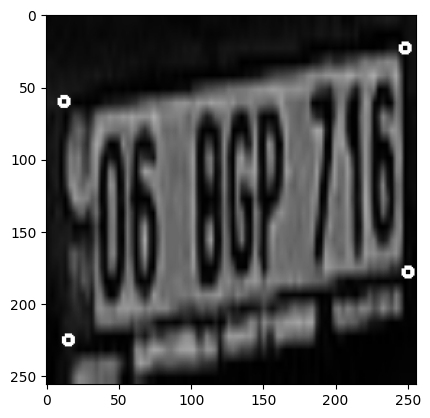

In [116]:
predictor("/content/Yolo_06BGP716_Paddle_06BGP716_plate0.jpg")

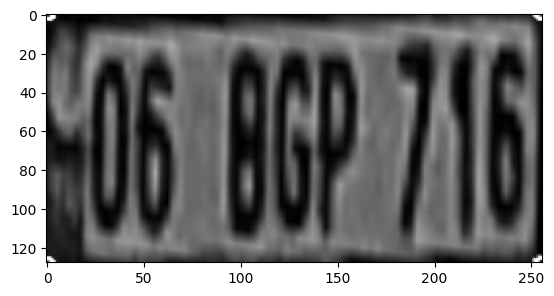

In [117]:
warp_pred()

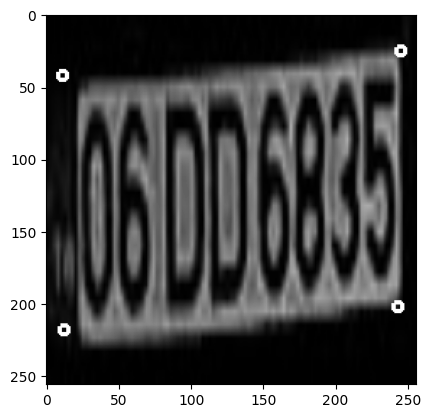

In [118]:
predictor("/content/Yolo_06DD6835_Paddle_06DD6835_plate0.jpg")

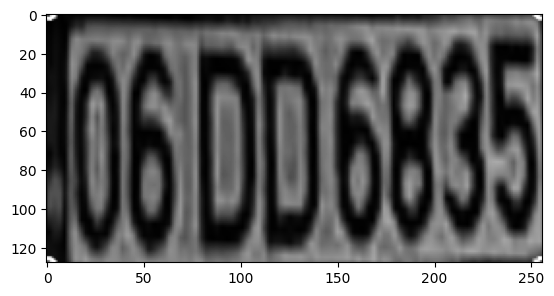

In [119]:
warp_pred()

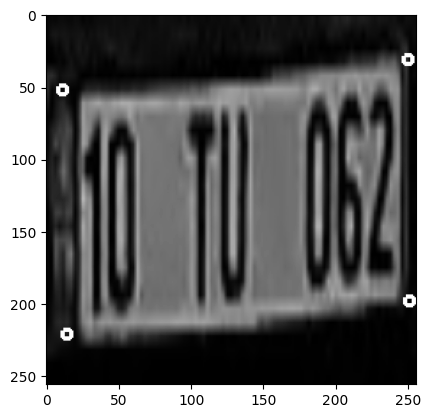

In [120]:
predictor("/content/Yolo_10TU062_Paddle_10TU062_plate0.jpg")

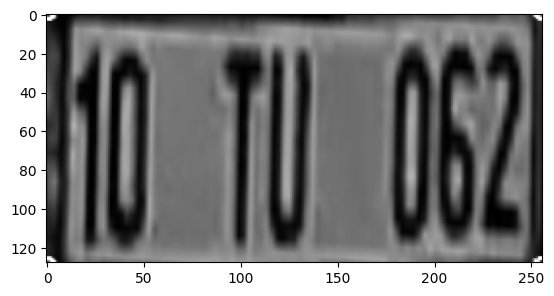

In [121]:
warp_pred()

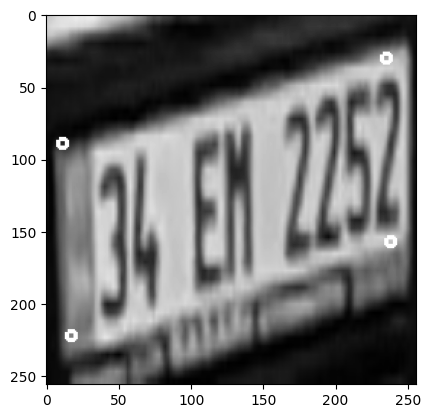

In [122]:
predictor("/content/Yolo_34EM2252_Paddle_34EM2252_plate0.jpg")

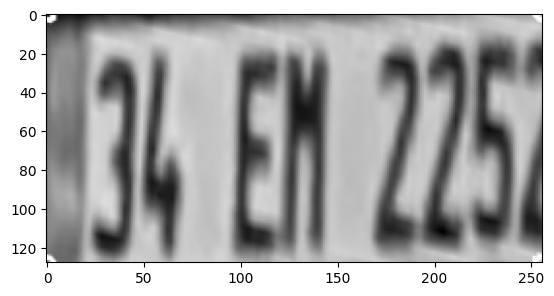

In [123]:
warp_pred()

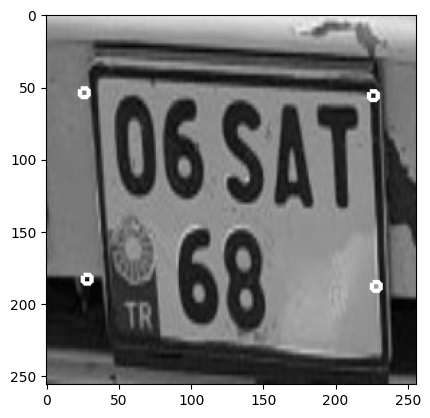

In [124]:
predictor("/content/06SAT68.jpg")

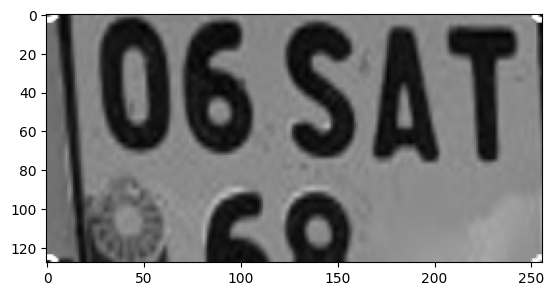

In [125]:
warp_pred()

In [128]:
!cp /content/kp_ep_normalized.pt /content/Drive/MyDrive/kp_ep_normalized_v2.pt

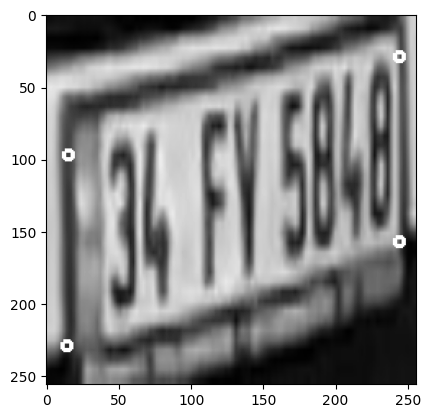

In [126]:
predictor("/content/Yolo_34FV5848_Paddle_34FV5848_plate0.jpg")

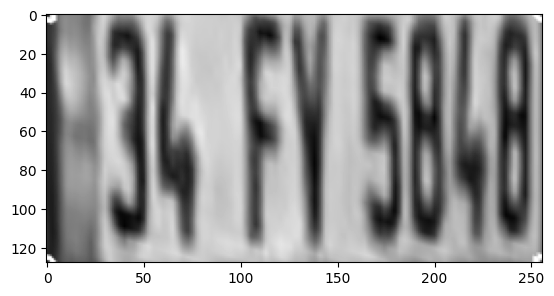

In [127]:
warp_pred()